#  Belajar Machine Learning untuk Pemula - Proyek Akhir : Klasifikasi Gambar


## Data Diri

Nama : Adi Bintang Pradana <br>
Alamat : Jl. Budi Mulia No. 1, Jakarta <br>
No. HP : 087784537428 <br>
Email : adibintangprada@gmail.com

## Import Library

In [1]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

## Load Dataset

In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-13 15:22:22--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  14.4MB/s    in 28s     

2021-07-13 15:22:50 (11.1 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
directory = '/tmp/rockpaperscissors/rps-cv-images'
print(os.listdir(directory))

['paper', 'rock', 'README_rpc-cv-images.txt', 'scissors']


In [5]:
labels = ['paper','scissors','rock']
nb = len(labels)

## Separating Images and Labels

In [6]:
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            img=load_img(os.path.join(folder,image), target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            dataset.append((img,count))
        print(f'\rCompleted: {label}',end='')
        count+=1
    random.shuffle(dataset)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)

In [7]:
X, y = input_target_split(directory,labels)

Completed: rock

## Visualizing the Images

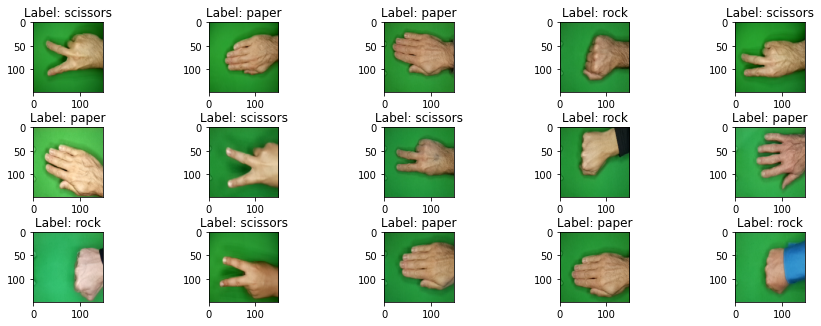

In [8]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title(f'Label: {labels[y[i]]}')

In [9]:
np.unique(y,return_counts=True)

(array([0, 1, 2]), array([712, 750, 726]))

## Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.399, random_state=42)
print(np.unique(y_train,return_counts=True),np.unique(y_test,return_counts=True))

(array([0, 1, 2]), array([422, 452, 440])) (array([0, 1, 2]), array([290, 298, 286]))


## Image Augmentation

In [11]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range=0.1,
                             fill_mode="nearest")

testgen = ImageDataGenerator()

datagen.fit(X_train)
testgen.fit(X_test)

In [12]:
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

## Creating Model Architecture

In [13]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

## Model Compiling

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               21234176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

## Defining Callback and Best Model Checkpoint

In [16]:
filepath= "image_classification.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta = 0, 
                               patience = 5, 
                               verbose = 1, 
                               restore_best_weights=True)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print("\nAkurasi telah mencapai >96%!")
      self.model.stop_training = True
callbacks = myCallback()

callback_params = [checkpoint,
                   early_stopping,
                   callbacks]

## Run the Model

In [17]:
hist = model.fit(datagen.flow(X_train,y_train,batch_size=32),
                validation_data=testgen.flow(X_test,y_test,batch_size=32),
                epochs=50,
                callbacks=callback_params)

Epoch 1/50
42/42 [==============================] - 50s 1s/step - loss: 1.7828 - accuracy: 0.3653 - val_loss: 1.0516 - val_accuracy: 0.4943

Epoch 00001: val_accuracy improved from -inf to 0.49428, saving model to image_classification.h5
Epoch 2/50
42/42 [==============================] - 49s 1s/step - loss: 1.0024 - accuracy: 0.4840 - val_loss: 0.7538 - val_accuracy: 0.7597

Epoch 00002: val_accuracy improved from 0.49428 to 0.75973, saving model to image_classification.h5
Epoch 3/50
42/42 [==============================] - 48s 1s/step - loss: 0.9521 - accuracy: 0.5426 - val_loss: 0.7017 - val_accuracy: 0.8101

Epoch 00003: val_accuracy improved from 0.75973 to 0.81007, saving model to image_classification.h5
Epoch 4/50
42/42 [==============================] - 49s 1s/step - loss: 0.7804 - accuracy: 0.6446 - val_loss: 0.5022 - val_accuracy: 0.8204

Epoch 00004: val_accuracy improved from 0.81007 to 0.82037, saving model to image_classification.h5
Epoch 5/50
42/42 [=====================

In [18]:
best_model = tf.keras.models.load_model("image_classification.h5")

## Loss and Accuracy Visualization

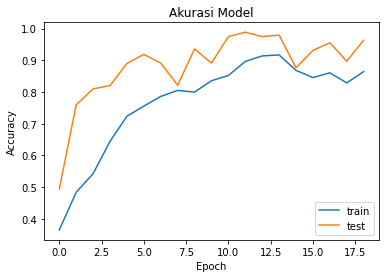

In [19]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

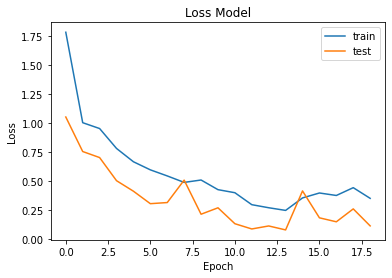

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Image Classification Function

Saving 0a3UtNzl5Ll3sq8K.png to 0a3UtNzl5Ll3sq8K (18).png
0a3UtNzl5Ll3sq8K.png
paper


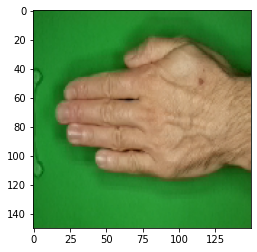

In [27]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150,1))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = best_model.predict(images, batch_size=10)

  paper = np.array([[1., 0., 0.]], dtype='float32')
  scissors = np.array([[0., 1., 0.]], dtype='float32')
  
  print(fn)
  if np.array_equal(classes, paper)==True:
    print('paper')
  elif np.array_equal(classes, scissors)==True:
    print('scissors')
  else:
    print('rock')